## 1. Searching for gold inside HTML files
<p>It used to take days for financial news to spread via radio, newspapers, and word of mouth. News articles can be <em>automatically</em> generated from figures and earnings call streams. Hedge funds and independent traders are use data science to process this wealth of information in the quest for profit.</p>
<p>In this notebook, sentiment analysis will be used to extract insight from financial news headlines from <a href="https://finviz.com">FINVIZ.com</a>. This will  help in better understanding the emotion behind the headlines and predict whether the market <em>feels</em> good or bad about a stock. It would then be possible to make educated guesses on how certain stocks will perform and trade accordingly. (And hopefully, make money!)</p>
<p><img src="https://assets.datacamp.com/production/project_611/img/fb_headlines.png" alt="Facebook headlines from FINVIZ.com"></p>
<p>Why headlines? And why from FINVIZ?</p>
<ol>
<li>Headlines, which have similar length, are easier to parse and group than full articles, which vary in length.</li>
<li>FINVIZ has a list of trusted websites, and headlines from these sites tend to be more consistent in their jargon than those from independent bloggers. Consistent textual patterns will improve the sentiment analysis.</li>
</ol>

In [369]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [370]:
# Import libraries
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import os
import glob
import datetime

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from bs4 import BeautifulSoup

In [371]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [372]:
html_tables = {}

folder = '/content/drive/MyDrive/dataset_finviz/'

# List all html files
files = glob.glob(folder + '*.html')

for table_path in files:
  with open(table_path, 'r') as table_file:
    table_name = os.path.basename(table_path)
    # Read the contents of the file into 'html'
    html = BeautifulSoup(table_file, 'html.parser')
    # Find 'news-table' in the Soup and load it into 'html_table'
    html_table = html.find(id='news-table')
    # Add the table to our dictionary
    html_tables[table_name] = html_table

## 2. What is inside those files anyway?
<p>The table containing the headlines has been grabbed from each stock's HTML file, but before parsing those tables further, there is need to understand how the data in that table is structured.

In [373]:
# Read one single day of headlines
tsla = html_tables['tsla_22sep.html']

# Get all the table rows tagged in HTML with <tr> into 'tesla_tr'
tsla_tr = tsla.find_all('tr')

# For each row...
for i, table_row in enumerate(tsla_tr):
    # Read the text of the element 'a' into 'link_text'
    link_text = table_row.a.get_text()

    # Read the text of the element 'td' into 'data_text'
    data_text =  table_row.td.get_text()
    # Print the count
    print(f'File number {i+1}:')
    # Print the contents of 'link_text' and 'data_text'
    print(link_text)
    print(data_text)
    # limit the rows due to prevent spaming the notebook
    if i == 3:
        break

File number 1:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
File number 2:
Broadcoms Stock Looks Like a Winner
09:30PM  
File number 3:
SHAREHOLDER ALERT:  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
File number 4:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


## 3. Extra, extra! Extract the news headlines
<p>As seen above, the interesting data inside each table row (<code>&lt;tr&gt;</code>) is in the text inside the <code>&lt;td&gt;</code> and <code>&lt;a&gt;</code> tags.</p>

In [374]:
# Hold the parsed news into a list
parsed_news = []
# Iterate through the news
for file_name, news_table in html_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Read the text from the tr tag into text
        text = x.a.get_text()
        # Split the text in the td tag into a list
        date_scrape = x.td.text.split()
        # If the length of 'date_scrape' is 1, load 'time' as the only element
        # If not, load 'date' as the 1st element and 'time' as the second
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Extract the ticker from the file name, get the string up to the 1st '_'
        underscore_index = file_name.find('_')
        ticker = file_name[:underscore_index]
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])

## 4. Make NLTK think like a financial journalist
<p>Sentiment analysis demonstrates a keen ability to discern varied interpretations contingent upon the context. For instance, the phrase "This is so addictive!" may convey positivity in the context of enjoying a video game with friends, yet it frequently carries negative connotations when referring to substances like opioids. It's important to recognize that the choice of headlines as our dataset stems from the intention to gauge sentiment from financial journalists, who, like many professionals, utilize specialized language. Therefore, in an effort to enhance NLTK's comprehension of financial news, additional words and their corresponding sentiments are being incorporated into its lexicon.</p>

In [375]:
# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()

In [376]:
# Update the lexicon
vader.lexicon.update(new_words)

## 5. BREAKING NEWS: NLTK Crushes Sentiment Estimates
<p>With the data and algorithm ready, the next step involves predicting sentiment from news headlines programmatically. Fortunately, VADER operates at a high level, requiring no further adjustments to the model apart from the earlier lexicon additions.

However, it's important to note that using VADER "out-of-the-box," even with some extra words included, may result in significant financial losses if applied directly to real money trading. To develop a sentiment analysis tool with potential profitability, a more extensive and specialized lexicon tailored to finance news would be necessary. Additionally, relying solely on a pre-packaged model like VADER might not yield optimal outcomes.</p>

In [377]:
# Use these column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news,columns=columns)

# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(x) for x in scored_news.headline]

# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames
scored_news = scored_news.join(scores_df)

# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date, format='%b-%d-%y').dt.date

## 6. Plot all the sentiment in subplots
<p>Time series plot of the stocks.</p>

<Axes: xlabel='date'>

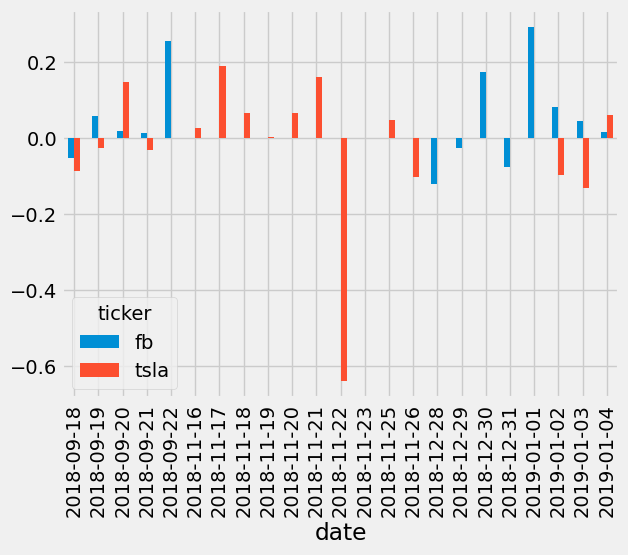

In [378]:
plt.style.use("fivethirtyeight")

# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.drop(columns=['time','headline']).groupby(['date','ticker']).mean()

mean_c = mean_c.unstack('ticker')

# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs("compound", axis="columns")

# Plot a bar chart with pandas
mean_c.plot.bar()

## 7. Weekends and duplicates
<p>On November 22nd, Tesla experienced notable events. An examination of the headlines within the <code>DataFrame</code> reveals specific issues for that day: </p>
<ul>
<li>There are only 5 headlines for that day.</li>
<li>Two headlines are verbatim the same as another but from another news outlet.</li>
</ul>
<p>To improve the dataset's quality, it is necessary to clean it up while retaining valuable information. Although some headlines might report the same news from different sources, the variation in wording can offer diverse perspectives on the same story. Additionally, when a piece of news is particularly significant, it often receives more coverage from multiple sources. The goal is to remove only the verbatim duplicate headlines, as they are likely from the same journalist and are merely being redistributed.</p>

In [379]:
scored_news['headline'].unique()

selected_date = datetime.date(2018, 11, 22)
result = scored_news.loc[(scored_news['date'] == selected_date) & (scored_news['ticker']== 'tsla')]

print(result['headline'][:4])

126    Tesla Cuts China Car Prices: Can Others Surviv...
127    [$$] Tesla cuts prices in China as trade war b...
128    Tesla Lowers Car Prices in China After Trade W...
129    Tesla cuts China car prices to absorb hit from...
Name: headline, dtype: object


In [380]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = scored_news.headline.count()

# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset=['headline', 'ticker'])

# Count number of headlines after dropping duplicates (store as integer)
num_news_after = scored_news_clean.headline.count()

# Print before and after numbers to get an idea of how we did
f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 500 headlines, now we have 476'

## 8. Sentiment on one single trading day and stock
<p>To understand the dataset better, the focus will be on one trading day and one stock. An informative plot will be made to show the headlines and their scores in detail..</p>

In [381]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])

# Cross-section the fb row
single_day = single_day.xs('fb')

# Select the 3rd of January of 2019
specific_date = datetime.date(2019, 1, 3)
single_day = single_day.loc[specific_date]

# Convert the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time']).dt.time

# Set the index to time and sort by it
single_day = single_day.set_index('time')

# Sort it
single_day = single_day.sort_index()

print(single_day.head())

                                                   headline    neg    neu  \
time                                                                        
06:00:00  Why Internet Censorship Doesnt Work and Never ...  0.000  1.000   
08:04:00  3 Big Stock Charts for Thursday: Medtronic, Fa...  0.000  1.000   
09:07:00  The Zacks Analyst Blog Highlights: Facebook, W...  0.000  0.846   
09:12:00  Why The FAANGs Are Crucial To A 2019 Market Rally  0.000  1.000   
09:34:00  Apple warning stoking fears of slowdown in Chi...  0.426  0.574   

            pos  compound  
time                       
06:00:00  0.000    0.0000  
08:04:00  0.000    0.0000  
09:07:00  0.154    0.2500  
09:12:00  0.000    0.0000  
09:34:00  0.000   -0.6369  


<ipython-input-381-0e49df568780>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  single_day['time'] = pd.to_datetime(single_day['time']).dt.time


## 9. Visualize the single day
<p>Plot to visualize the positive, negative, and neutral scores for a single trading day and a single stock.





</p>

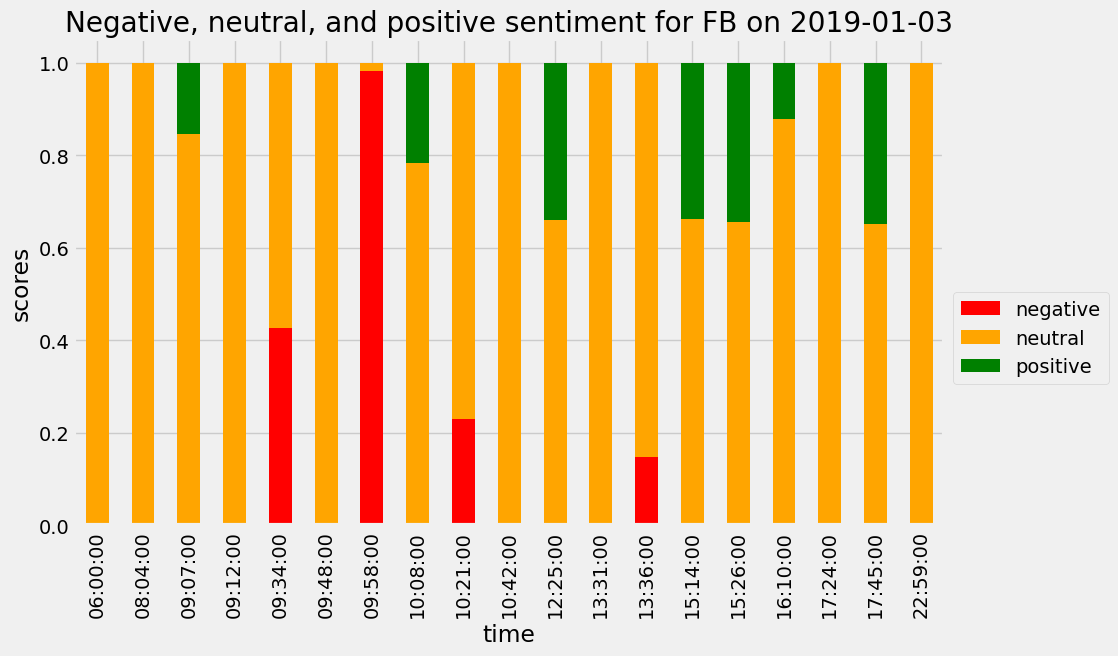

In [382]:
TITLE = "Negative, neutral, and positive sentiment for FB on 2019-01-03"
COLORS = ["red","orange", "green"]

# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(columns=['compound','headline'])

# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative','neutral','positive']

plot_day.plot.bar(stacked = True,
                  figsize=(10, 6),
                  title = TITLE,
                  color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel('scores');
